# Proyecto Semestral - Entrega final

Luciano Davico  
Gregory Schuit  

En el presente notebook se presenta el análisis de datos sobre terremotos y tsunamis, especificamente mediante la implementación de un Random Forest para poder discriminar entre terremotos que ocasionan tsunamis y los que no.

In [1]:
import pandas as pd
import numpy as np
from time import time

# Data Preprocessing

In [2]:
# Leemos los datos de terremotos y filtramos las features.
quakes_df = pd.read_csv('Data/quakes.csv')
print(len(quakes_df))
quakes_df.columns

415677


Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst',
       'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource'],
      dtype='object')

In [3]:
quakes_df = quakes_df[['latitude', 'longitude', 'depth', 'mag', 'time']]
quakes_df.head()

,latitude,longitude,depth,mag,time
0,37.6457,20.8702,10.00,4.7,2018-10-27T18:33:12.420Z
1,65.2234,-151.6636,16.60,5.3,2018-10-27T16:57:27.956Z
2,-22.4704,-68.6516,113.79,4.7,2018-10-27T15:46:43.390Z
3,-56.0652,-27.4276,93.78,4.9,2018-10-27T15:00:46.800Z
4,37.3128,20.4930,10.00,4.6,2018-10-27T14:33:26.470Z


In [4]:
min(quakes_df['time'])

'1900-07-29T06:59:00.000Z'

In [5]:
# Leemos los dato de tsunamis y seleccionamos las features
tsunamis_df = pd.read_csv('Data/tsunamis.tsv', sep='\t', encoding='iso-8859-1')
tsunamis_df = tsunamis_df[tsunamis_df['YEAR'] >= 1900]
tsunamis_df = tsunamis_df[['PRIMARY_MAGNITUDE', 'LATITUDE', 'LONGITUDE', 'YEAR']]
print(len(tsunamis_df))
tsunamis_df.head()

773


,PRIMARY_MAGNITUDE,LATITUDE,LONGITUDE,YEAR
372,6.6,-4.0,152.0,1900
373,7.1,-5.0,148.0,1900
374,6.9,-4.0,140.0,1900
375,8.4,11.0,-66.0,1900
376,6.0,39.0,143.0,1901


Es posibe observar que existen 415677 terremotos y tan solo 1145 tsunamis. Este problema de desbalance se nivelará filtrando intervalos con muchos terremotos y pocos tsunamis, es decir, el rango de magnitudes bajas. A continuación observaremos los datos para determinar un punto de corte.

In [6]:
# Observamos distribuciones de la magnitud
plt = tsunamis_df['PRIMARY_MAGNITUDE'].hist(bins=40, figsize=(10, 3))

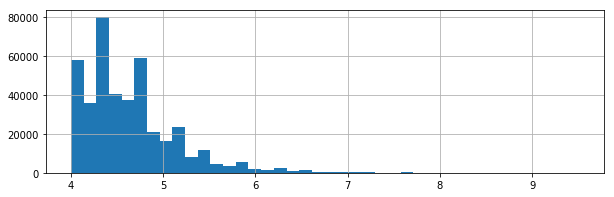

In [7]:
plt = quakes_df['mag'].hist(bins=40, figsize=(10, 3))

A partir de los histogramas, es posible apreciar que la gran mayoria de los terremotos bajo 6 grados aproximadamente, no genera tsunami alguno. Por esta razón es que lo consideraremos como el punto de corte.

In [8]:
corte = 6.3
print(len(tsunamis_df[tsunamis_df['PRIMARY_MAGNITUDE'] > corte]))
print(len(quakes_df[quakes_df['mag'] > corte]))

663
4930


In [9]:
tsunamis_df = tsunamis_df[tsunamis_df['PRIMARY_MAGNITUDE'] > corte]
quakes_df = quakes_df[quakes_df['mag'] > corte]

Ahora, procederemos a hacer el join de ambas tablas

In [10]:
# Creamos una nueva columna en el dataset de terremotos,
# que por defecto será la ausencia de tsunami.
quakes_df['tsunami'] = 0

t0, i, total = time(), 0, len(quakes_df)
for index, row in quakes_df.iterrows():  # Para cada terremoto, se busca la correspondencia
    lat = row['latitude']                # en la tabla tsunamis.
    lon = row['longitude']
    mag = row['mag']
    year = int(row['time'][:4])
    
    delta_pos = 2.5  # valores tuneados a mano para el margen de error.
    delta_mag = 0.3
    
    cond1 = abs(tsunamis_df['LATITUDE'] - lat) < delta_pos
    cond2 = abs(tsunamis_df['LONGITUDE'] - lon) < delta_pos
    cond3 = abs(tsunamis_df['PRIMARY_MAGNITUDE'] - mag) < delta_mag
    cond4 = tsunamis_df['YEAR'] == year
    
    # Si existe un elemento en la tabla de tsunamis con las features muy cercanas,
    # se le asocia al terremoto.
    if len(tsunamis_df.loc[cond1 & cond2 & cond3 & cond4]) >= 1:
        quakes_df.at[index, 'tsunami'] = 1
    else:
        quakes_df.at[index, 'tsunami'] = 0
    
    i += 1
    if i % 80 == 0:
        print('Seconds left: {:.2f}'.format((time() - t0)/i * (total - i)), end='\r')

print('Total time: {:.2f}'.format(time() - t0))
len(quakes_df[quakes_df['tsunami'] == 1]), len(tsunamis_df)

Total time: 25.3969


(671, 663)

In [11]:
quakes_df.head()

,latitude,longitude,depth,mag,time,tsunami
79,37.5055,20.5626,14.00,6.8,2018-10-25T22:54:51.830Z,1
147,49.3142,-129.6725,10.00,6.5,2018-10-22T06:22:48.810Z,0
148,49.3468,-129.2135,10.00,6.8,2018-10-22T06:16:28.160Z,0
149,49.2496,-129.4783,10.96,6.6,2018-10-22T05:39:40.330Z,0
335,-21.7260,169.4867,10.00,6.4,2018-10-16T01:03:43.090Z,0


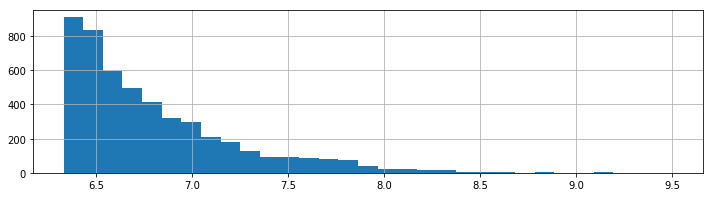

In [12]:
# Magnitudes de todos los terremotos
plt = quakes_df['mag'].hist(bins=31, figsize=(12,3))

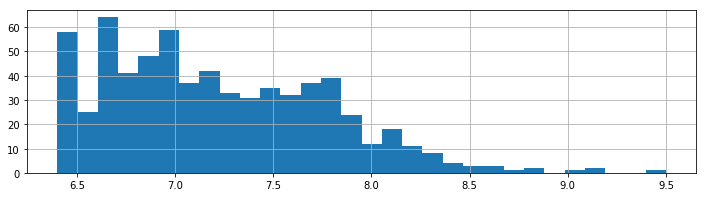

In [13]:
# Magnitudes de terremotos que provocaron tsunamis
plt = quakes_df[quakes_df['tsunami'] == 1]['mag'].hist(bins=30, figsize=(12,3))

### Train and test

Debido al desbalance de los datos, la partición de sets de training y testing se hará estratificada.

(3943, 987)

In [15]:
train.head()

,latitude,longitude,depth,mag,tsunami
7982,-5.5321,151.4999,35.000,6.9,0
126866,40.6520,-124.6925,28.737,6.5,0
297516,-3.6090,135.4040,10.000,7.1,0
256695,41.6790,-125.8560,1.303,7.0,0
361686,39.4020,143.5850,25.000,6.5,0


# Random Forest

<center>$Entropy(S) = p \cdot Log(p)$</center>

In [16]:
class Node:
    """
    EDD principal para generar un árbol de regresión.
    """
    
    def __init__(self, feature=None, division_point=None, leaf=False, data=None):
        self.left_child = None  # de la clase Node
        self.right_child = None  # de la clase Node
        self.feature = feature  # Atributo que instancian sus hijos
        self.division_point = division_point  # punto de division que separa a sus hijos
        self.leaf = leaf  # Indica si es un nodo hoja
        self.data = data  # Si es que es un nodo hoja, contiene las particiones de los datos
        
    @property
    def depth(self):
        d = 0
        if self.left_child:
            d = 1 + self.left_child.depth
        if self.right_child:
            d = max(d, 1 + self.right_child.depth)
        return d
    
    @property
    def number_of_leaves(self):
        if self.leaf:
            return 1
        return self.left_child.number_of_leaves + self.right_child.number_of_leaves
    
    @property
    def total_var(self):
        if self.leaf:
            return self.data['tsunami'].var(ddof=0)
        return self.left_child.total_var + self.right_child.total_var
        
    def __repr__(self):
        if not self.leaf:
            ret = "feature: {}\ndivision_point: {}\ndepth: {}\nleaves: {}".format(self.feature,
                                                                                  self.division_point,
                                                                                  self.depth,
                                                                                  self.number_of_leaves)
        else:
            ret = "Hoja\nNúmero de datos: {}\nMean: {}\nstd: {}".format(len(self.data),
                                                                        self.data.mean(),
                                                                        self.data.std(ddof=0))
        return ret

In [17]:
def entropy(data_left, data_right):
    p_left = len(data_left[data_left['tsunami'] == 0]) / len(data_left)
    p_right = len(data_right[data_right['tsunami'] == 1]) / len(data_left)
    

In [18]:
def best_division_point(data, feature, target):
    """
    Calcula las varianzas de manera incremental para cada dato como punto divisorio
    de los datos y entrega el index del que minimiza la varianza.
    """
    
    print("Computing best division point for feature {}...                 ".format(feature), end='\r')
    t0 = time()
    
    if len(data[feature].unique()) == 1:  # si todos los valores de feature son iguales
        return 0, float('inf'), 0
    
    # Ordenamos los datos según la feature
    ordered = data.sort_values(feature)
    total = len(ordered)

    # Entropia base
    p0 = len(data[data[target] == 0]) / len(data)
    p1 = len(data[data[target] == 1]) / len(data)
    e = p0*np.log2(p0) + p1*np.log2(p1)
        
    # Maximizar el gain es lo mismo que minimizar la entropia de las particiones.
    data_left = ordered[:1]
    data_right = ordered[1:]
        
    p0_left = len(data_left[data_left[target] == 0])
    p0_right = len(data_right[data_right[target] == 0])
    
    p1_left = len(data_left[data_left[target] == 1])
    p1_right = len(data_right[data_right[target] == 1])
    
    e_left = p0_left*np.log2(p0_left) + p1_left*np.log2(p1_left) if p0_left != 0 and p1_left != 0 else 0
    e_right = p0_right*np.log2(p0_right) + p1_right*np.log2(p1_right) if p0_right != 0 and p1_right != 0 else 0
    
    leaves_entropy = e_left + e_right  # cantidad a minimizar
    minimum, best_division = float('inf'), 0

    datos_feature = list(data[feature])
    dato_anterior = datos_feature[0]
    for i, row in enumerate(data[target][1:]):               
        if data.iloc[i + 1][target] == 0:
            p0_left += 1
            p0_right -= 1
        else:
            p1_left += 1
            p1_right -= 1
    
        e_left = p0_left * np.log2(p0_left) + p1_left * np.log2(p1_left) if p0_left != 0 and p1_left != 0 else 0
        e_right = p0_right * np.log2(p0_right) + p1_right * np.log2(p1_right) if p0_right != 0 and p1_right != 0 else 0
    
        new_entropy = e_left + e_right
        if new_entropy < minimum:  # cantidad a minimizar
            if datos_feature[i + 1] == dato_anterior:  # esto es para que el corte no 
                continue                               # divida datos iguales
            minimum, best_division = new_entropy, i + 1
        
        dato_anterior = datos_feature[i + 1]


    # retornamos el index del mejor punto de división junto con la varianza obtenidax
    idxs_left = [ordered.index[idx] for idx in range(best_division + 1)]
    idxs_right = [ordered.index[idx] for idx in range(best_division + 1, len(ordered))]
    
    # print("Best division point founded for {} in {:.4f} seconds.".format(feature, time() - t0))
    return ordered.index[best_division], minimum, [idxs_left, idxs_right]

In [37]:
def prepoda(datos):
    if len(datos) < 5:#len(quakes_df)*0.05:
        return True
    return False

def fit(data, target, max_depth=None):
    """
    Función recursiva para generar el árbol de regresión óptimo.
    """
    
    # Condición de término:
    if max_depth == 0 or prepoda(data):
        hoja = Node(leaf=True)
        hoja.data = data
        return hoja
    
    t0 = time()
    print("Computing best feature... Depth: {}".format(max_depth))
    
    features = [col for col in data.columns if col != target]

    best_feature = features[0]
    best_point, best_minimum, best_idxs = best_division_point(data, best_feature, target)
    for feature in features[1:]:
        point, minimum, idxs = best_division_point(data, feature, target)
        if minimum < best_minimum:
            best_feature = feature
            best_point = point
            best_minimum = minimum
            best_idxs = idxs  # filas de la particion
    
    print("Best feature found in {:.4f} seconds: {}, division_point: {}.".format(time() - t0, best_feature, best_point))
    
    print("Creating childs...")
    root = Node(feature=best_feature, division_point=data[best_feature][best_point])
    
    left_data = data.loc[best_idxs[0]]
    right_data = data.loc[best_idxs[1]]
    
    root.left_child = fit(left_data, target, max_depth - 1 if max_depth else None)
    print("Left child ready. Current time: {:.4f} seconds".format(time() - t0))
    root.right_child = fit(right_data, target, max_depth - 1 if max_depth else None)
    print("Right child ready. Current time: {:.4f} seconds".format(time() - t0))
    
    return root   

In [38]:
def predict(row, tree, target='tsunami'):
    """
    Recorre un árbol de regresión para predecir la clase del dato entregado.
    """
    
    # Buscamos la hoja
    while not tree.leaf:
        if row[tree.feature] < tree.division_point:
            tree = tree.left_child
        else:
            tree = tree.right_child
    
    # Predecimos en base a lo que haya en la hoja
    return tree.data[target].mean()

In [39]:
regression_tree = fit(train, 'tsunami', 50)

Computing best feature... Depth: 50
Best feature found in 5.1267 seconds: latitude, division_point: 355788.
Creating childs...
Computing best feature... Depth: 49
Best feature found in 4.3826 seconds: latitude, division_point: 117309.
Creating childs...
Computing best feature... Depth: 48
Best feature found in 2.3563 seconds: latitude, division_point: 119705.
Creating childs...
Computing best feature... Depth: 47


/home/gregschuit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in log2


Best feature found in 1.1857 seconds: depth, division_point: 94691.
Creating childs...
Computing best feature... Depth: 46
Best feature found in 0.5687 seconds: depth, division_point: 19861.    
Creating childs...
Computing best feature... Depth: 45
Best feature found in 0.4221 seconds: latitude, division_point: 202250.
Creating childs...
Computing best feature... Depth: 44
Best feature found in 0.1943 seconds: latitude, division_point: 254556.
Creating childs...
Computing best feature... Depth: 43
Best feature found in 0.1188 seconds: latitude, division_point: 74716. 
Creating childs...
Computing best feature... Depth: 42
Best feature found in 0.0899 seconds: latitude, division_point: 79247. 
Creating childs...
Computing best feature... Depth: 41
Best feature found in 0.0550 seconds: latitude, division_point: 198502.
Creating childs...
Left child ready. Current time: 0.0585 seconds
Computing best feature... Depth: 40
Computing best division point for feature mag...                    

/home/gregschuit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log2
/home/gregschuit/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


Best feature found in 0.0428 seconds: latitude, division_point: 274163.
Creating childs...
Left child ready. Current time: 0.0458 seconds
Computing best feature... Depth: 39
Best feature found in 0.0389 seconds: latitude, division_point: 339600.
Creating childs...
Left child ready. Current time: 0.0426 seconds
Right child ready. Current time: 0.0427 seconds
Right child ready. Current time: 0.0887 seconds
Right child ready. Current time: 0.1476 seconds
Left child ready. Current time: 0.2437 seconds
Computing best feature... Depth: 41
Best feature found in 0.0463 seconds: latitude, division_point: 269866.
Creating childs...
Computing best feature... Depth: 40
Best feature found in 0.0519 seconds: latitude, division_point: 287147.
Creating childs...
Left child ready. Current time: 0.0547 seconds
Computing best feature... Depth: 39
Best feature found in 0.0385 seconds: latitude, division_point: 276817.
Creating childs...
Left child ready. Current time: 0.0424 seconds
Computing best feature

Best feature found in 0.0373 seconds: latitude, division_point: 360539.
Creating childs...
Left child ready. Current time: 0.0397 seconds
Right child ready. Current time: 0.0398 seconds
Right child ready. Current time: 0.0824 seconds
Right child ready. Current time: 0.5681 seconds
Right child ready. Current time: 1.0001 seconds
Right child ready. Current time: 1.3618 seconds
Right child ready. Current time: 2.8892 seconds
Left child ready. Current time: 3.3142 seconds
Computing best feature... Depth: 44
Best feature found in 0.1577 seconds: depth, division_point: 216023.   
Creating childs...
Computing best feature... Depth: 43
Best feature found in 0.1010 seconds: latitude, division_point: 321951.
Creating childs...
Computing best feature... Depth: 42
Best feature found in 0.0636 seconds: latitude, division_point: 324157.
Creating childs...
Computing best feature... Depth: 41
Best feature found in 0.0499 seconds: latitude, division_point: 78174. 
Creating childs...
Left child ready. C

Best feature found in 0.3521 seconds: latitude, division_point: 357438.
Creating childs...
Computing best feature... Depth: 44
Best feature found in 0.1923 seconds: latitude, division_point: 356331.
Creating childs...
Computing best feature... Depth: 43
Best feature found in 0.0936 seconds: latitude, division_point: 358976.
Creating childs...
Left child ready. Current time: 0.0971 seconds
Computing best feature... Depth: 42
Best feature found in 0.0903 seconds: latitude, division_point: 341545.
Creating childs...
Left child ready. Current time: 0.0941 seconds
Computing best feature... Depth: 41
Best feature found in 0.1027 seconds: latitude, division_point: 358581.
Creating childs...
Left child ready. Current time: 0.1055 seconds
Computing best feature... Depth: 40
Best feature found in 0.0882 seconds: latitude, division_point: 359553.
Creating childs...
Left child ready. Current time: 0.0923 seconds
Computing best feature... Depth: 39
Best feature found in 0.1030 seconds: latitude, di

Best feature found in 0.0994 seconds: latitude, division_point: 356075.
Creating childs...
Computing best feature... Depth: 40
Best feature found in 0.0783 seconds: latitude, division_point: 124357.
Creating childs...
Computing best feature... Depth: 39
Best feature found in 0.0652 seconds: longitude, division_point: 358704.
Creating childs...
Left child ready. Current time: 0.0720 seconds
Computing best feature... Depth: 38
Best feature found in 0.0835 seconds: latitude, division_point: 125719.
Creating childs...
Left child ready. Current time: 0.0936 seconds
Right child ready. Current time: 0.0940 seconds
Right child ready. Current time: 0.1662 seconds
Left child ready. Current time: 0.2483 seconds
Computing best feature... Depth: 39
Best feature found in 0.0858 seconds: latitude, division_point: 359719.
Creating childs...
Left child ready. Current time: 0.0888 seconds
Right child ready. Current time: 0.0891 seconds
Right child ready. Current time: 0.3375 seconds
Left child ready. Cu

Computing best feature... Depth: 39
Best feature found in 0.0429 seconds: latitude, division_point: 254941.
Creating childs...
Left child ready. Current time: 0.0458 seconds
Right child ready. Current time: 0.0459 seconds
Left child ready. Current time: 0.0918 seconds
Right child ready. Current time: 0.0918 seconds
Right child ready. Current time: 0.1974 seconds
Right child ready. Current time: 0.4750 seconds
Right child ready. Current time: 1.0344 seconds
Right child ready. Current time: 2.3565 seconds
Right child ready. Current time: 6.4390 seconds
Right child ready. Current time: 13.0469 seconds
Left child ready. Current time: 14.2378 seconds
Computing best feature... Depth: 46
Best feature found in 0.7190 seconds: depth, division_point: 102511.   
Creating childs...
Computing best feature... Depth: 45
Best feature found in 0.4973 seconds: latitude, division_point: 315706.
Creating childs...
Computing best feature... Depth: 44
Best feature found in 0.2691 seconds: latitude, division

Best feature found in 0.0698 seconds: latitude, division_point: 207271.
Creating childs...
Left child ready. Current time: 0.0760 seconds
Computing best feature... Depth: 38
Best feature found in 0.0619 seconds: latitude, division_point: 196068.
Creating childs...
Left child ready. Current time: 0.0681 seconds
Computing best feature... Depth: 37
Best feature found in 0.0602 seconds: latitude, division_point: 250760.
Creating childs...
Left child ready. Current time: 0.0680 seconds
Right child ready. Current time: 0.0684 seconds
Right child ready. Current time: 0.1371 seconds
Right child ready. Current time: 0.2139 seconds
Right child ready. Current time: 0.2838 seconds
Right child ready. Current time: 0.4815 seconds
Right child ready. Current time: 1.4558 seconds
Left child ready. Current time: 1.6610 seconds
Computing best feature... Depth: 42
Best feature found in 0.1421 seconds: latitude, division_point: 357219.
Creating childs...
Computing best feature... Depth: 41
Best feature fou

Computing best feature... Depth: 40
Best feature found in 0.0533 seconds: depth, division_point: 357134.   
Creating childs...
Computing best feature... Depth: 39
Best feature found in 0.0391 seconds: latitude, division_point: 183755.
Creating childs...
Left child ready. Current time: 0.0428 seconds
Right child ready. Current time: 0.0431 seconds
Left child ready. Current time: 0.0995 seconds
Computing best feature... Depth: 39
Best feature found in 0.0583 seconds: latitude, division_point: 345516.
Creating childs...
Left child ready. Current time: 0.0619 seconds
Computing best feature... Depth: 38
Best feature found in 0.0358 seconds: latitude, division_point: 150862.
Creating childs...
Left child ready. Current time: 0.0382 seconds
Right child ready. Current time: 0.0389 seconds
Right child ready. Current time: 0.1013 seconds
Right child ready. Current time: 0.2009 seconds
Left child ready. Current time: 0.2723 seconds
Computing best feature... Depth: 40
Best feature found in 0.0473 

Best feature found in 0.0630 seconds: latitude, division_point: 94214. 
Creating childs...
Left child ready. Current time: 0.0674 seconds
Right child ready. Current time: 0.0678 seconds
Right child ready. Current time: 0.1163 seconds
Right child ready. Current time: 0.1612 seconds
Right child ready. Current time: 0.2062 seconds
Right child ready. Current time: 0.2545 seconds
Right child ready. Current time: 0.3113 seconds
Right child ready. Current time: 0.3634 seconds
Right child ready. Current time: 0.4242 seconds
Right child ready. Current time: 0.4853 seconds
Right child ready. Current time: 0.5514 seconds
Left child ready. Current time: 0.6313 seconds
Computing best feature... Depth: 41
Best feature found in 0.0493 seconds: latitude, division_point: 103034.
Creating childs...
Computing best feature... Depth: 40
Best feature found in 0.0434 seconds: latitude, division_point: 103041.
Creating childs...
Left child ready. Current time: 0.0459 seconds
Right child ready. Current time: 0

Computing best feature... Depth: 7
Best feature found in 0.0814 seconds: latitude, division_point: 356463.
Creating childs...
Left child ready. Current time: 0.0852 seconds
Computing best feature... Depth: 6
Best feature found in 0.0725 seconds: latitude, division_point: 221261.
Creating childs...
Left child ready. Current time: 0.0758 seconds
Computing best feature... Depth: 5
Best feature found in 0.0693 seconds: latitude, division_point: 250922.
Creating childs...
Left child ready. Current time: 0.0728 seconds
Computing best feature... Depth: 4
Best feature found in 0.0679 seconds: latitude, division_point: 401734.
Creating childs...
Left child ready. Current time: 0.0709 seconds
Computing best feature... Depth: 3
Best feature found in 0.0662 seconds: latitude, division_point: 297830.
Creating childs...
Left child ready. Current time: 0.0697 seconds
Computing best feature... Depth: 2
Best feature found in 0.0638 seconds: latitude, division_point: 282400.
Creating childs...
Left chil

Best feature found in 0.0578 seconds: latitude, division_point: 260744.
Creating childs...
Left child ready. Current time: 0.0639 seconds
Computing best feature... Depth: 35
Best feature found in 0.0524 seconds: latitude, division_point: 361963.
Creating childs...
Left child ready. Current time: 0.0549 seconds
Computing best feature... Depth: 34
Best feature found in 0.0470 seconds: latitude, division_point: 341521.
Creating childs...
Left child ready. Current time: 0.0505 seconds
Computing best feature... Depth: 33
Best feature found in 0.0440 seconds: latitude, division_point: 13463. 
Creating childs...
Left child ready. Current time: 0.0471 seconds
Computing best feature... Depth: 32
Best feature found in 0.0419 seconds: latitude, division_point: 344500.
Creating childs...
Left child ready. Current time: 0.0450 seconds
Computing best feature... Depth: 31
Best feature found in 0.0394 seconds: latitude, division_point: 230042.
Creating childs...
Left child ready. Current time: 0.0418 

Left child ready. Current time: 0.0446 seconds
Right child ready. Current time: 0.0449 seconds
Right child ready. Current time: 0.1787 seconds
Right child ready. Current time: 0.2790 seconds
Left child ready. Current time: 0.4018 seconds
Computing best feature... Depth: 41
Best feature found in 0.0734 seconds: latitude, division_point: 324896.
Creating childs...
Computing best feature... Depth: 40
Best feature found in 0.0615 seconds: longitude, division_point: 70952.
Creating childs...
Computing best feature... Depth: 39
Best feature found in 0.0464 seconds: latitude, division_point: 339699.
Creating childs...
Computing best feature... Depth: 38
Best feature found in 0.0425 seconds: latitude, division_point: 324267.
Creating childs...
Left child ready. Current time: 0.0450 seconds
Right child ready. Current time: 0.0450 seconds
Left child ready. Current time: 0.0939 seconds
Computing best feature... Depth: 38
Best feature found in 0.0400 seconds: latitude, division_point: 176935.
Crea

Best feature found in 0.0380 seconds: latitude, division_point: 298161.
Creating childs...
Left child ready. Current time: 0.0405 seconds
Right child ready. Current time: 0.0406 seconds
Right child ready. Current time: 0.0810 seconds
Left child ready. Current time: 0.1262 seconds
Right child ready. Current time: 0.1262 seconds
Right child ready. Current time: 0.3639 seconds
Right child ready. Current time: 0.6563 seconds
Right child ready. Current time: 0.9326 seconds
Left child ready. Current time: 1.1159 seconds
Computing best feature... Depth: 43
Best feature found in 0.0989 seconds: latitude, division_point: 85013. 
Creating childs...
Computing best feature... Depth: 42
Best feature found in 0.0640 seconds: latitude, division_point: 407671.
Creating childs...
Computing best feature... Depth: 41
Best feature found in 0.0378 seconds: latitude, division_point: 399195.
Creating childs...
Left child ready. Current time: 0.0407 seconds
Right child ready. Current time: 0.0410 seconds
Left

Best feature found in 0.0455 seconds: latitude, division_point: 340309.
Creating childs...
Left child ready. Current time: 0.0484 seconds
Computing best feature... Depth: 38
Best feature found in 0.0360 seconds: latitude, division_point: 406653.
Creating childs...
Left child ready. Current time: 0.0386 seconds
Right child ready. Current time: 0.0389 seconds
Right child ready. Current time: 0.0873 seconds
Left child ready. Current time: 0.1390 seconds
Computing best feature... Depth: 39
Best feature found in 0.0399 seconds: latitude, division_point: 356460.
Creating childs...
Left child ready. Current time: 0.0424 seconds
Right child ready. Current time: 0.0427 seconds
Right child ready. Current time: 0.1819 seconds
Left child ready. Current time: 0.2439 seconds
Computing best feature... Depth: 40
Best feature found in 0.0386 seconds: latitude, division_point: 3516.
Creating childs...
Left child ready. Current time: 0.0410 seconds
Computing best feature... Depth: 39
Best feature found i

Left child ready. Current time: 0.0405 seconds
Right child ready. Current time: 0.0409 seconds
Right child ready. Current time: 0.0833 seconds
Right child ready. Current time: 0.1274 seconds
Right child ready. Current time: 0.1738 seconds
Right child ready. Current time: 0.2229 seconds
Right child ready. Current time: 2.0413 seconds
Right child ready. Current time: 4.4984 seconds
Right child ready. Current time: 10.9105 seconds
Left child ready. Current time: 12.0469 seconds
Computing best feature... Depth: 46
Best feature found in 0.6087 seconds: latitude, division_point: 201474.
Creating childs...
Computing best feature... Depth: 45
Best feature found in 0.3706 seconds: latitude, division_point: 283732.
Creating childs...
Computing best feature... Depth: 44
Best feature found in 0.3447 seconds: longitude, division_point: 356005.
Creating childs...
Computing best feature... Depth: 43
Best feature found in 0.0675 seconds: latitude, division_point: 258871.
Creating childs...
Computing b

Computing best feature... Depth: 40
Best feature found in 0.0782 seconds: longitude, division_point: 356440.
Creating childs...
Computing best feature... Depth: 39
Best feature found in 0.0485 seconds: latitude, division_point: 383270.
Creating childs...
Left child ready. Current time: 0.0516 seconds
Computing best feature... Depth: 38
Best feature found in 0.0407 seconds: latitude, division_point: 341497.
Creating childs...
Left child ready. Current time: 0.0450 seconds
Right child ready. Current time: 0.0453 seconds
Right child ready. Current time: 0.0970 seconds
Left child ready. Current time: 0.1803 seconds
Computing best feature... Depth: 39
Best feature found in 0.0866 seconds: latitude, division_point: 67424. 
Creating childs...
Computing best feature... Depth: 38
Best feature found in 0.0735 seconds: depth, division_point: 251792.   
Creating childs...
Computing best feature... Depth: 37
Best feature found in 0.0416 seconds: latitude, division_point: 251792.
Creating childs...


Best feature found in 0.0589 seconds: latitude, division_point: 357542.
Creating childs...
Left child ready. Current time: 0.0632 seconds
Computing best feature... Depth: 32
Best feature found in 0.0710 seconds: latitude, division_point: 356758.
Creating childs...
Left child ready. Current time: 0.0770 seconds
Computing best feature... Depth: 31
Best feature found in 0.0827 seconds: latitude, division_point: 264411.
Creating childs...
Left child ready. Current time: 0.0856 seconds
Right child ready. Current time: 0.0859 seconds
Right child ready. Current time: 0.1632 seconds
Right child ready. Current time: 0.2266 seconds
Right child ready. Current time: 0.2728 seconds
Right child ready. Current time: 0.3221 seconds
Right child ready. Current time: 0.3753 seconds
Right child ready. Current time: 0.4325 seconds
Right child ready. Current time: 0.4957 seconds
Right child ready. Current time: 0.5628 seconds
Right child ready. Current time: 0.6561 seconds
Right child ready. Current time: 0

Best feature found in 0.0539 seconds: longitude, division_point: 307028.
Creating childs...
Computing best feature... Depth: 39
Best feature found in 0.0572 seconds: latitude, division_point: 252611.
Creating childs...
Left child ready. Current time: 0.0630 seconds
Right child ready. Current time: 0.0632 seconds
Left child ready. Current time: 0.1224 seconds
Right child ready. Current time: 0.1224 seconds
Right child ready. Current time: 0.2142 seconds
Right child ready. Current time: 0.5277 seconds
Left child ready. Current time: 0.6742 seconds
Computing best feature... Depth: 42
Best feature found in 0.1265 seconds: longitude, division_point: 280133.
Creating childs...
Computing best feature... Depth: 41
Best feature found in 0.0760 seconds: longitude, division_point: 337086.
Creating childs...
Computing best feature... Depth: 40
Best feature found in 0.0480 seconds: latitude, division_point: 357475.
Creating childs...
Left child ready. Current time: 0.0504 seconds
Computing best fea

Computing best feature... Depth: 41
Best feature found in 0.0735 seconds: depth, division_point: 357069.   
Creating childs...
Computing best feature... Depth: 40
Best feature found in 0.0471 seconds: latitude, division_point: 407512.
Creating childs...
Computing best feature... Depth: 39
Best feature found in 0.0392 seconds: latitude, division_point: 357638.
Creating childs...
Left child ready. Current time: 0.0419 seconds
Computing best feature... Depth: 38
Best feature found in 0.0371 seconds: latitude, division_point: 357069.
Creating childs...
Left child ready. Current time: 0.0401 seconds
Right child ready. Current time: 0.0401 seconds
Right child ready. Current time: 0.0823 seconds
Left child ready. Current time: 0.1319 seconds
Computing best feature... Depth: 39
Best feature found in 0.0371 seconds: latitude, division_point: 356752.
Creating childs...
Left child ready. Current time: 0.0395 seconds
Right child ready. Current time: 0.0395 seconds
Right child ready. Current time: 

Best feature found in 0.1658 seconds: latitude, division_point: 356900.
Creating childs...
Left child ready. Current time: 0.1684 seconds
Computing best feature... Depth: 39
Best feature found in 0.0753 seconds: latitude, division_point: 340909.
Creating childs...
Left child ready. Current time: 0.0781 seconds
Computing best feature... Depth: 38
Best feature found in 0.1287 seconds: latitude, division_point: 356518.
Creating childs...
Left child ready. Current time: 0.1312 seconds
Computing best feature... Depth: 37
Best feature found in 0.0791 seconds: latitude, division_point: 343313.
Creating childs...
Left child ready. Current time: 0.0816 seconds
Computing best feature... Depth: 36
Best feature found in 0.0691 seconds: latitude, division_point: 357615.
Creating childs...
Left child ready. Current time: 0.0716 seconds
Computing best feature... Depth: 35
Best feature found in 0.0930 seconds: latitude, division_point: 295290.
Creating childs...
Left child ready. Current time: 0.1000 

Best feature found in 0.0439 seconds: latitude, division_point: 285945.
Creating childs...
Left child ready. Current time: 0.0464 seconds
Computing best feature... Depth: 35
Best feature found in 0.0386 seconds: latitude, division_point: 355946.
Creating childs...
Left child ready. Current time: 0.0411 seconds
Computing best feature... Depth: 34
Best feature found in 0.0560 seconds: latitude, division_point: 355996.
Creating childs...
Left child ready. Current time: 0.0589 seconds
Right child ready. Current time: 0.0590 seconds
Right child ready. Current time: 0.1005 seconds
Right child ready. Current time: 0.1472 seconds
Right child ready. Current time: 0.2017 seconds
Right child ready. Current time: 0.2622 seconds
Right child ready. Current time: 0.3216 seconds
Right child ready. Current time: 0.3860 seconds
Right child ready. Current time: 0.4443 seconds
Right child ready. Current time: 0.5052 seconds
Right child ready. Current time: 1.2214 seconds
Left child ready. Current time: 1.

Best feature found in 0.0466 seconds: latitude, division_point: 355929.
Creating childs...
Left child ready. Current time: 0.0490 seconds
Computing best feature... Depth: 40
Best feature found in 0.0441 seconds: latitude, division_point: 163786.
Creating childs...
Left child ready. Current time: 0.0483 seconds
Computing best feature... Depth: 39
Best feature found in 0.0610 seconds: latitude, division_point: 384602.
Creating childs...
Left child ready. Current time: 0.0642 seconds
Computing best feature... Depth: 38
Best feature found in 0.0400 seconds: latitude, division_point: 359959.
Creating childs...
Left child ready. Current time: 0.0424 seconds
Computing best feature... Depth: 37
Best feature found in 0.0375 seconds: latitude, division_point: 357318.
Creating childs...
Left child ready. Current time: 0.0399 seconds
Right child ready. Current time: 0.0402 seconds
Right child ready. Current time: 0.0827 seconds
Right child ready. Current time: 0.1471 seconds
Right child ready. Cur

Computing best feature... Depth: 39
Best feature found in 0.0670 seconds: latitude, division_point: 356013.
Creating childs...
Left child ready. Current time: 0.0702 seconds
Computing best feature... Depth: 38
Best feature found in 0.0418 seconds: latitude, division_point: 411063.
Creating childs...
Left child ready. Current time: 0.0443 seconds
Computing best feature... Depth: 37
Best feature found in 0.0381 seconds: latitude, division_point: 356300.
Creating childs...
Left child ready. Current time: 0.0408 seconds
Computing best feature... Depth: 36
Best feature found in 0.0359 seconds: latitude, division_point: 357577.
Creating childs...
Left child ready. Current time: 0.0386 seconds
Right child ready. Current time: 0.0387 seconds
Right child ready. Current time: 0.0795 seconds
Right child ready. Current time: 0.1239 seconds
Right child ready. Current time: 0.1946 seconds
Left child ready. Current time: 0.2910 seconds
Computing best feature... Depth: 39
Best feature found in 0.0421 

Left child ready. Current time: 0.0637 seconds
Computing best feature... Depth: 39
Best feature found in 0.0788 seconds: latitude, division_point: 355999.
Creating childs...
Left child ready. Current time: 0.0826 seconds
Computing best feature... Depth: 38
Best feature found in 0.0470 seconds: latitude, division_point: 356698.
Creating childs...
Left child ready. Current time: 0.0495 seconds
Right child ready. Current time: 0.0496 seconds
Right child ready. Current time: 0.1324 seconds
Right child ready. Current time: 0.1965 seconds
Right child ready. Current time: 0.2423 seconds
Right child ready. Current time: 0.2941 seconds
Left child ready. Current time: 0.4205 seconds
Computing best feature... Depth: 42
Best feature found in 0.0988 seconds: longitude, division_point: 121483.
Creating childs...
Computing best feature... Depth: 41
Best feature found in 0.0761 seconds: latitude, division_point: 356691.
Creating childs...
Computing best feature... Depth: 40
Best feature found in 0.058

Best feature found in 0.0519 seconds: latitude, division_point: 322405.
Creating childs...
Left child ready. Current time: 0.0549 seconds
Computing best feature... Depth: 39
Best feature found in 0.0498 seconds: latitude, division_point: 79880. 
Creating childs...
Left child ready. Current time: 0.0523 seconds
Computing best feature... Depth: 38
Best feature found in 0.0842 seconds: latitude, division_point: 348510.
Creating childs...
Left child ready. Current time: 0.0870 seconds
Computing best feature... Depth: 37
Best feature found in 0.0485 seconds: latitude, division_point: 357301.
Creating childs...
Left child ready. Current time: 0.0510 seconds
Computing best feature... Depth: 36
Best feature found in 0.0466 seconds: latitude, division_point: 360057.
Creating childs...
Left child ready. Current time: 0.0491 seconds
Computing best feature... Depth: 35
Best feature found in 0.0449 seconds: latitude, division_point: 357015.
Creating childs...
Left child ready. Current time: 0.0478 

Best feature found in 0.3390 seconds: latitude, division_point: 281987.
Creating childs...
Computing best feature... Depth: 44
Best feature found in 0.1891 seconds: latitude, division_point: 378923.
Creating childs...
Computing best feature... Depth: 43
Best feature found in 0.1019 seconds: latitude, division_point: 362413.
Creating childs...
Computing best feature... Depth: 42
Best feature found in 0.0716 seconds: latitude, division_point: 18496. 
Creating childs...
Computing best feature... Depth: 41
Best feature found in 0.0472 seconds: latitude, division_point: 357493.
Creating childs...
Left child ready. Current time: 0.0497 seconds
Right child ready. Current time: 0.0500 seconds
Left child ready. Current time: 0.1242 seconds
Computing best feature... Depth: 41
Best feature found in 0.0708 seconds: longitude, division_point: 357044.
Creating childs...
Computing best feature... Depth: 40
Best feature found in 0.0456 seconds: latitude, division_point: 314587.
Creating childs...
Left

Best feature found in 0.0673 seconds: depth, division_point: 372989.   
Creating childs...
Computing best feature... Depth: 41
Best feature found in 0.0679 seconds: latitude, division_point: 66304. 
Creating childs...
Computing best feature... Depth: 40
Best feature found in 0.0698 seconds: depth, division_point: 66304.    
Creating childs...
Left child ready. Current time: 0.0729 seconds
Computing best feature... Depth: 39
Best feature found in 0.0408 seconds: mag, division_point: 356743.     
Creating childs...
Left child ready. Current time: 0.0445 seconds
Right child ready. Current time: 0.0447 seconds
Right child ready. Current time: 0.1178 seconds
Left child ready. Current time: 0.1909 seconds
Computing best feature... Depth: 40
Best feature found in 0.0440 seconds: latitude, division_point: 341220.
Creating childs...
Left child ready. Current time: 0.0474 seconds
Computing best feature... Depth: 39
Best feature found in 0.0379 seconds: latitude, division_point: 356734.
Creating 

Best feature found in 0.0453 seconds: latitude, division_point: 356427.
Creating childs...
Left child ready. Current time: 0.0489 seconds
Computing best feature... Depth: 37
Best feature found in 0.0589 seconds: latitude, division_point: 186221.
Creating childs...
Left child ready. Current time: 0.0623 seconds
Computing best feature... Depth: 36
Best feature found in 0.0389 seconds: latitude, division_point: 186166.
Creating childs...
Left child ready. Current time: 0.0420 seconds
Right child ready. Current time: 0.0421 seconds
Right child ready. Current time: 0.1046 seconds
Right child ready. Current time: 0.1537 seconds
Right child ready. Current time: 0.2003 seconds
Right child ready. Current time: 0.2494 seconds
Left child ready. Current time: 0.3152 seconds
Computing best feature... Depth: 40
Best feature found in 0.0444 seconds: latitude, division_point: 186252.
Creating childs...
Computing best feature... Depth: 39
Best feature found in 0.0401 seconds: mag, division_point: 34116

Best feature found in 0.3183 seconds: latitude, division_point: 360670.
Creating childs...
Computing best feature... Depth: 44
Best feature found in 0.1511 seconds: latitude, division_point: 362482.
Creating childs...
Computing best feature... Depth: 43
Best feature found in 0.1191 seconds: latitude, division_point: 258360.
Creating childs...
Computing best feature... Depth: 42
Best feature found in 0.0508 seconds: latitude, division_point: 403793.
Creating childs...
Left child ready. Current time: 0.0533 seconds
Computing best feature... Depth: 41
Best feature found in 0.0420 seconds: latitude, division_point: 49057. 
Creating childs...
Left child ready. Current time: 0.0444 seconds
Computing best feature... Depth: 40
Best feature found in 0.0388 seconds: latitude, division_point: 279567.
Creating childs...
Left child ready. Current time: 0.0413 seconds
Computing best feature... Depth: 39
Best feature found in 0.0365 seconds: latitude, division_point: 82254. 
Creating childs...
Left c

Best feature found in 0.0602 seconds: latitude, division_point: 362117.
Creating childs...
Left child ready. Current time: 0.0644 seconds
Computing best feature... Depth: 41
Best feature found in 0.0708 seconds: latitude, division_point: 357670.
Creating childs...
Left child ready. Current time: 0.0744 seconds
Computing best feature... Depth: 40
Best feature found in 0.0531 seconds: latitude, division_point: 356664.
Creating childs...
Left child ready. Current time: 0.0562 seconds
Computing best feature... Depth: 39
Best feature found in 0.0437 seconds: latitude, division_point: 357421.
Creating childs...
Left child ready. Current time: 0.0472 seconds
Computing best feature... Depth: 38
Best feature found in 0.0462 seconds: latitude, division_point: 370284.
Creating childs...
Left child ready. Current time: 0.0522 seconds
Right child ready. Current time: 0.0523 seconds
Right child ready. Current time: 0.0996 seconds
Right child ready. Current time: 0.1561 seconds
Right child ready. Cur

Best feature found in 0.6092 seconds: latitude, division_point: 355646.
Creating childs...
Computing best feature... Depth: 45
Best feature found in 0.3501 seconds: longitude, division_point: 355927.
Creating childs...
Computing best feature... Depth: 44
Best feature found in 0.1708 seconds: mag, division_point: 357655.     
Creating childs...
Computing best feature... Depth: 43
Best feature found in 0.1335 seconds: latitude, division_point: 196926.
Creating childs...
Computing best feature... Depth: 42
Best feature found in 0.0616 seconds: latitude, division_point: 357395.
Creating childs...
Computing best feature... Depth: 41
Best feature found in 0.0583 seconds: latitude, division_point: 357572.
Creating childs...
Left child ready. Current time: 0.0615 seconds
Computing best feature... Depth: 40
Best feature found in 0.0545 seconds: latitude, division_point: 76217. 
Creating childs...
Left child ready. Current time: 0.0576 seconds
Computing best feature... Depth: 39
Best feature fou

Computing best feature... Depth: 43
Best feature found in 0.0914 seconds: latitude, division_point: 358325.
Creating childs...
Computing best feature... Depth: 42
Best feature found in 0.0520 seconds: latitude, division_point: 357400.
Creating childs...
Computing best feature... Depth: 41
Best feature found in 0.0381 seconds: latitude, division_point: 220308.
Creating childs...
Computing best feature... Depth: 40
Best feature found in 0.0375 seconds: latitude, division_point: 357399.
Creating childs...
Left child ready. Current time: 0.0399 seconds
Right child ready. Current time: 0.0400 seconds
Left child ready. Current time: 0.0806 seconds
Right child ready. Current time: 0.0806 seconds
Left child ready. Current time: 0.1352 seconds
Computing best feature... Depth: 41
Best feature found in 0.0397 seconds: latitude, division_point: 357508.
Creating childs...
Left child ready. Current time: 0.0423 seconds
Computing best feature... Depth: 40
Best feature found in 0.0375 seconds: latitud

Best feature found in 0.1842 seconds: depth, division_point: 357434.   
Creating childs...
Computing best feature... Depth: 43
Best feature found in 0.0992 seconds: latitude, division_point: 357613.
Creating childs...
Computing best feature... Depth: 42
Best feature found in 0.0669 seconds: latitude, division_point: 356899.
Creating childs...
Computing best feature... Depth: 41
Best feature found in 0.0467 seconds: latitude, division_point: 341168.
Creating childs...
Computing best feature... Depth: 40
Best feature found in 0.0423 seconds: latitude, division_point: 360303.
Creating childs...
Left child ready. Current time: 0.0457 seconds
Computing best feature... Depth: 39
Best feature found in 0.0374 seconds: latitude, division_point: 356995.
Creating childs...
Left child ready. Current time: 0.0405 seconds
Right child ready. Current time: 0.0406 seconds
Right child ready. Current time: 0.0864 seconds
Left child ready. Current time: 0.1365 seconds
Right child ready. Current time: 0.13

Best feature found in 0.0997 seconds: latitude, division_point: 356726.
Creating childs...
Computing best feature... Depth: 42
Best feature found in 0.0757 seconds: longitude, division_point: 362175.
Creating childs...
Computing best feature... Depth: 41
Best feature found in 0.0618 seconds: latitude, division_point: 357468.
Creating childs...
Computing best feature... Depth: 40
Best feature found in 0.0505 seconds: depth, division_point: 185038.   
Creating childs...
Left child ready. Current time: 0.0532 seconds
Computing best feature... Depth: 39
Best feature found in 0.0485 seconds: latitude, division_point: 356019.
Creating childs...
Computing best feature... Depth: 38
Best feature found in 0.0417 seconds: latitude, division_point: 186967.
Creating childs...
Left child ready. Current time: 0.0455 seconds
Computing best feature... Depth: 37
Best feature found in 0.0406 seconds: latitude, division_point: 361024.
Creating childs...
Left child ready. Current time: 0.0435 seconds
Right

Best feature found in 0.9547 seconds: latitude, division_point: 319729.
Creating childs...
Computing best feature... Depth: 48
Best feature found in 0.7457 seconds: latitude, division_point: 357068.
Creating childs...
Computing best feature... Depth: 47
Best feature found in 0.4001 seconds: depth, division_point: 361565.   
Creating childs...
Computing best feature... Depth: 46
Best feature found in 0.3295 seconds: depth, division_point: 355684.   
Creating childs...
Computing best feature... Depth: 45
Best feature found in 0.1484 seconds: latitude, division_point: 356283.
Creating childs...
Computing best feature... Depth: 44
Best feature found in 0.0893 seconds: latitude, division_point: 357574.
Creating childs...
Computing best feature... Depth: 43
Best feature found in 0.0979 seconds: latitude, division_point: 254889.
Creating childs...
Computing best feature... Depth: 42
Best feature found in 0.0623 seconds: latitude, division_point: 280892.
Creating childs...
Computing best featu

Best feature found in 0.1012 seconds: latitude, division_point: 341075.
Creating childs...
Computing best feature... Depth: 43
Best feature found in 0.0756 seconds: latitude, division_point: 356473.
Creating childs...
Computing best feature... Depth: 42
Best feature found in 0.0494 seconds: latitude, division_point: 340644.
Creating childs...
Left child ready. Current time: 0.0557 seconds
Computing best feature... Depth: 41
Best feature found in 0.0912 seconds: latitude, division_point: 359285.
Creating childs...
Computing best feature... Depth: 40
Best feature found in 0.0697 seconds: latitude, division_point: 354701.
Creating childs...
Left child ready. Current time: 0.0746 seconds
Right child ready. Current time: 0.0790 seconds
Left child ready. Current time: 0.1733 seconds
Computing best feature... Depth: 40
Best feature found in 0.0539 seconds: latitude, division_point: 354713.
Creating childs...
Left child ready. Current time: 0.0573 seconds
Right child ready. Current time: 0.057

Best feature found in 0.0813 seconds: latitude, division_point: 341996.
Creating childs...
Computing best feature... Depth: 45
Best feature found in 0.0770 seconds: depth, division_point: 356178.   
Creating childs...
Computing best feature... Depth: 44
Best feature found in 0.0418 seconds: latitude, division_point: 356178.
Creating childs...
Computing best feature... Depth: 43
Best feature found in 0.0396 seconds: latitude, division_point: 410832.
Creating childs...
Left child ready. Current time: 0.0435 seconds
Right child ready. Current time: 0.0438 seconds
Left child ready. Current time: 0.0892 seconds
Right child ready. Current time: 0.0892 seconds
Left child ready. Current time: 0.1689 seconds
Computing best feature... Depth: 44
Best feature found in 0.0586 seconds: depth, division_point: 82101.    
Creating childs...
Left child ready. Current time: 0.0620 seconds
Computing best feature... Depth: 43
Best feature found in 0.0439 seconds: latitude, division_point: 341812.
Creating 

Best feature found in 0.1412 seconds: latitude, division_point: 357432.
Creating childs...
Computing best feature... Depth: 44
Best feature found in 0.0751 seconds: latitude, division_point: 267323.
Creating childs...
Computing best feature... Depth: 43
Best feature found in 0.0704 seconds: latitude, division_point: 340066.
Creating childs...
Computing best feature... Depth: 42
Best feature found in 0.0424 seconds: latitude, division_point: 342114.
Creating childs...
Left child ready. Current time: 0.0451 seconds
Computing best feature... Depth: 41
Best feature found in 0.0376 seconds: latitude, division_point: 357061.
Creating childs...
Left child ready. Current time: 0.0403 seconds
Right child ready. Current time: 0.0405 seconds
Right child ready. Current time: 0.0859 seconds
Left child ready. Current time: 0.1590 seconds
Computing best feature... Depth: 42
Best feature found in 0.0858 seconds: latitude, division_point: 341597.
Creating childs...
Computing best feature... Depth: 41
B

Best feature found in 0.0739 seconds: latitude, division_point: 380923.
Creating childs...
Computing best feature... Depth: 42
Best feature found in 0.0554 seconds: depth, division_point: 374737.   
Creating childs...
Computing best feature... Depth: 41
Best feature found in 0.0478 seconds: latitude, division_point: 374737.
Creating childs...
Computing best feature... Depth: 40
Best feature found in 0.0390 seconds: latitude, division_point: 362581.
Creating childs...
Left child ready. Current time: 0.0444 seconds
Right child ready. Current time: 0.0447 seconds
Left child ready. Current time: 0.0955 seconds
Computing best feature... Depth: 40
Best feature found in 0.0536 seconds: latitude, division_point: 357428.
Creating childs...
Computing best feature... Depth: 39
Best feature found in 0.0421 seconds: latitude, division_point: 211091.
Creating childs...
Left child ready. Current time: 0.0446 seconds
Right child ready. Current time: 0.0449 seconds
Left child ready. Current time: 0.101

Best feature found in 0.0766 seconds: latitude, division_point: 356952.
Creating childs...
Left child ready. Current time: 0.0822 seconds
Computing best feature... Depth: 36
Best feature found in 0.0738 seconds: latitude, division_point: 166316.
Creating childs...
Left child ready. Current time: 0.0782 seconds
Computing best feature... Depth: 35
Best feature found in 0.0779 seconds: latitude, division_point: 180083.
Creating childs...
Left child ready. Current time: 0.0813 seconds
Computing best feature... Depth: 34
Best feature found in 0.0740 seconds: latitude, division_point: 355731.
Creating childs...
Left child ready. Current time: 0.0774 seconds
Computing best feature... Depth: 33
Best feature found in 0.0707 seconds: latitude, division_point: 356454.
Creating childs...
Left child ready. Current time: 0.0744 seconds
Computing best feature... Depth: 32
Best feature found in 0.0654 seconds: latitude, division_point: 340902.
Creating childs...
Left child ready. Current time: 0.0681 

# Testing

In [30]:
def execute_test(test_set, tree, target='tsunami'):
    t0 = time()
    length = len(test_set)
    sse = 0
    for i in range(length):
        row = test_set.iloc[i]
        sse += (predict(row, tree) - row[target])**2
        if i % 10 == 0:
            print('Seconds left: {:.2f}...'.format((time()-t0)/(i+1) * (length-i-1)), end='\r')
    mse = sse / length
    print('Test finished in {:.2f} seconds.\nMSE: {:.3f}\nsqrtMSE: {:.3f}'.format(time()-t0, mse, mse**(1/2)))

In [31]:
execute_test(test, regression_tree)

Test finished in 0.56 seconds.
MSE: 0.115
sqrtMSE: 0.339


# Visualización

In [32]:
from graphviz import Digraph

In [33]:
def generador_ids():
    i = 0
    while True:
        yield i
        i += 1    
    
g = generador_ids()
def make_graph(tree, graph):

    text1 = '{}\n{:.5f}'.format(tree.feature, tree.division_point)
    
    if not tree.left_child.leaf:
        text_left = '{}\n{:.5f}'.format(tree.left_child.feature, tree.left_child.division_point)
        graph.edge(text1, text_left)
        make_graph(tree.left_child, graph)
    else:
        graph.edge(text1, 'hoja N{}'.format(next(g)))
    
    if not tree.right_child.leaf:
        text_right = '{}\n{:.5f}'.format(tree.right_child.feature, tree.right_child.division_point)
        graph.edge(text1, text_right)
        make_graph(tree.right_child, graph)
    else:
        graph.edge(text1, 'hoja N{}'.format(next(g)))

In [40]:
u = Digraph('regression_tree', filename='regression_tree.gv')
u.attr(size='6,6')
u.node_attr.update(color='lightblue2', style='filled')
    
make_graph(regression_tree, u)

u.view()

'regression_tree.gv.pdf'

In [43]:
regression_tree.depth

50